# Eps visualizations

In [24]:
from pathlib import Path
from hashlib import sha1
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

## Data Dependencies

```
../data/verb_morpho.csv 15c7c1
../data/eps_bert_train.joblib dd9525
../data/eps_bert_test.joblib 555b05
../data/models/lda_mr_c1c2.joblib 7e558a
../data/models/lda_mr_scaler.joblib acec12
```

In [2]:
paths = ["../data/verb_morpho.csv",          
         "../data/eps_bert_train.joblib",
         "../data/eps_bert_test.joblib",
         "../data/models/lda_mr_c1c2.joblib",
         "../data/models/lda_mr_scaler.joblib"]
for path_x in paths:
    h = sha1()
    h.update(Path(path_x).read_bytes())
    print(path_x, h.hexdigest()[:6])

../data/verb_morpho.csv 15c7c1
../data/eps_bert_train.joblib dd9525
../data/eps_bert_test.joblib 555b05
../data/models/lda_mr_c1c2.joblib 7e558a
../data/models/lda_mr_scaler.joblib acec12


## Load resources

In [3]:
train_eps = joblib.load("../data/eps_bert_train.joblib")
test_eps = joblib.load("../data/eps_bert_test.joblib")
lda = joblib.load("../data/models/lda_mr_c1c2.joblib")
scaler = joblib.load("../data/models/lda_mr_scaler.joblib")

C:\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LinearDiscriminantAnalysis from version 1.0.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
len(train_eps), len(test_eps)

(1240, 304)

## EDA

### Replicating classification scores

In [5]:
trainX = [x["vec"] for x in train_eps]
trainXeps = [x["vec"] + x["eps"] for x in train_eps]
trainY = [x["mr"] for x in train_eps]
testX = [x["vec"] for x in test_eps]
testXeps = [x["vec"] + x["eps"] for x in test_eps]
testY = [x["mr"] for x in test_eps]
train_epsNorm = np.linalg.norm(np.vstack(trainXeps), axis=1)
test_epsNorm = np.linalg.norm(np.vstack(testXeps), axis=1)

print("Train origin:  {:.4f}".format(lda.score(trainX, trainY)))
print("Train ori+eps: {:.4f}".format(lda.score(trainXeps, trainY)))
print("Test  origin:  {:.4f}".format(lda.score(testX, testY)))
print("Test  ori+eps: {:.4f}".format(lda.score(testXeps, testY)))

Train origin:  0.9331
Train ori+eps: 1.0000
Test  origin:  0.7138
Test  ori+eps: 0.7961


## Project to 2D (TSNE, LDA)

In [6]:
allX = np.vstack([trainX, trainXeps, testX, testXeps])
all_groups = np.array(["trainX"]*len(trainX) + ["trainXEps"]*len(trainXeps)
            + ["testX"]*len(testX) + ["testXEps"]*len(testXeps)) 
all_labels = trainY * 2 + testY * 2
assert allX.shape[0] == len(all_groups) == len(all_labels)

In [7]:
all_reducer = TSNE(init="pca", learning_rate="auto")
all_tsne = all_reducer.fit_transform(allX)

C:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [8]:
trainX_tsne = all_tsne[all_groups=="trainX", :]
trainXeps_tsne = all_tsne[all_groups=="trainXEps", :]
testX_tsne = all_tsne[all_groups=="testX", :]
testXeps_tsne = all_tsne[all_groups=="testXEps", :]
trainX_dc = lda.transform(trainX)
trainXeps_dc = lda.transform(trainXeps)
testX_dc = lda.transform(testX)
testXeps_dc = lda.transform(testXeps)

In [9]:
trainX_correct = lda.predict(trainX) == trainY
trainXeps_correct = lda.predict(trainXeps) == trainY
train_epsImprov = trainXeps_correct & ~trainX_correct

## Classification improvement

In [10]:
label_map = {k: i for i, k in enumerate(lda.classes_)}
def compute_prob_diffs(X, Xeps, Y):
    X_probs = lda.predict_proba(X)
    Xeps_probs = lda.predict_proba(Xeps)
    labelids = np.array([label_map[y] for y in Y]).reshape(-1,1)
    X_label_probs = np.take_along_axis(X_probs, labelids, axis=1).flatten()
    Xeps_label_probs = np.take_along_axis(Xeps_probs, labelids, axis=1).flatten()
    prob_diff = Xeps_label_probs - X_label_probs
    return prob_diff
train_prob_diffs = compute_prob_diffs(trainX, trainXeps, trainY)
test_prob_diffs = compute_prob_diffs(testX, testXeps, testY)

In [11]:
def plot_eps_grids(coords, coords_eps, labels, prob_diff, epsNorm, 
                   coord_type="LDA", split_type='train'):
    fig, axes = plt.subplots(2, 2, figsize=(10,10))
    sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=labels, ax=axes[0][0])
    sns.scatterplot(x=coords_eps[:,0], y=coords_eps[:,1], hue=labels, ax=axes[0][1])

    prob_mask = prob_diff > 0.05
    sns.scatterplot(x=coords[~prob_mask,0], y=coords[~prob_mask,1], 
                    ax=axes[1][0], color='#DDD')
    sns.scatterplot(x=coords[prob_mask,0], y=coords[prob_mask,1], 
                    hue=prob_diff[prob_mask], ax=axes[1][0], 
                    palette='Blues')

    sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=epsNorm, 
                    ax=axes[1][1], palette='Blues')
    axes[0][0].set_title(f"{coord_type} of {split_type}")
    axes[0][1].set_title(f"{coord_type} of {split_type}'s eps")
    axes[1][0].set_title(f"{coord_type} colored with prob_diff")
    axes[1][1].set_title(f"{coord_type} colored with epsNorm")    

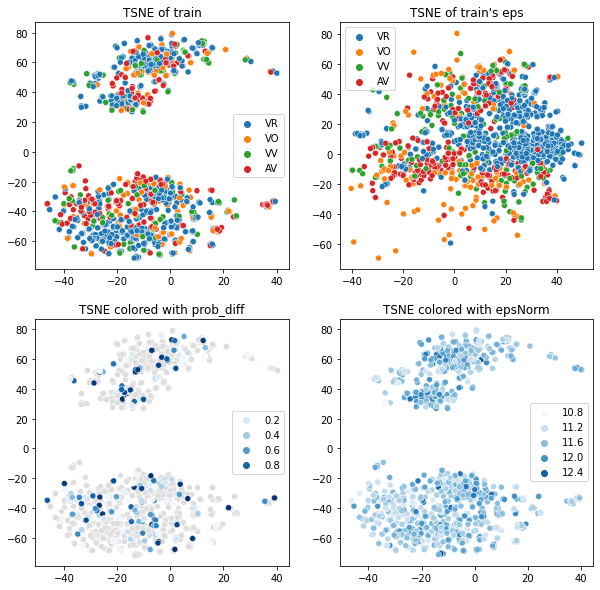

In [20]:
plot_eps_grids(trainX_tsne, trainXeps_tsne, trainY, train_prob_diffs, train_epsNorm, "TSNE", "train")

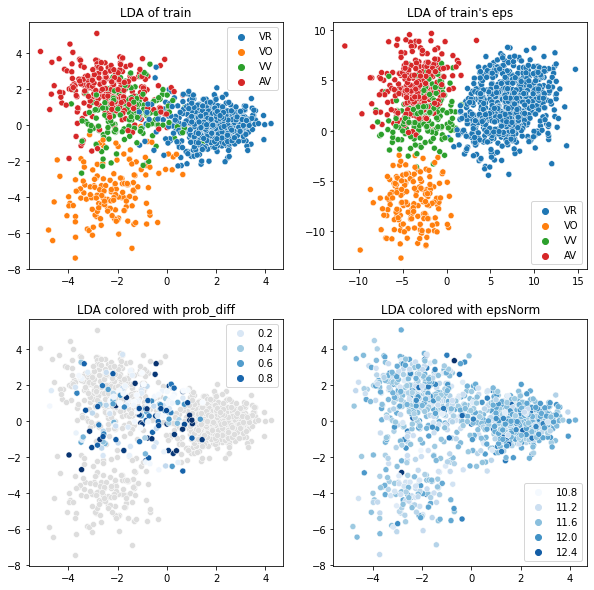

In [21]:
plot_eps_grids(trainX_dc, trainXeps_dc, trainY, train_prob_diffs, train_epsNorm, "LDA", "train")

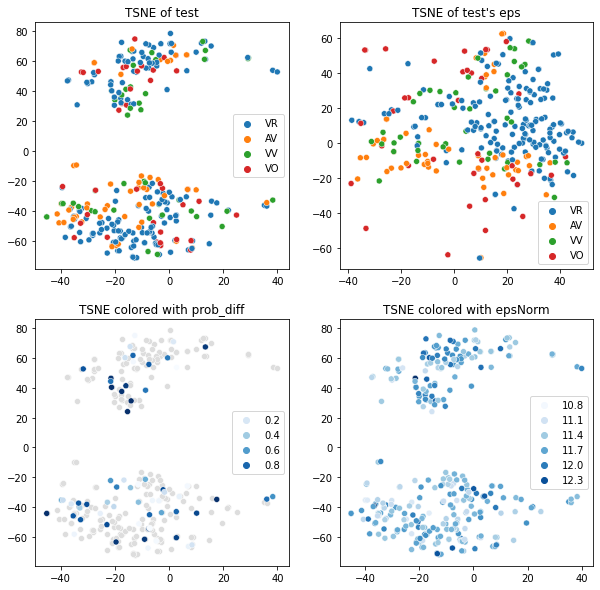

In [22]:
plot_eps_grids(testX_tsne, testXeps_tsne, testY, test_prob_diffs, test_epsNorm, "TSNE", "test")

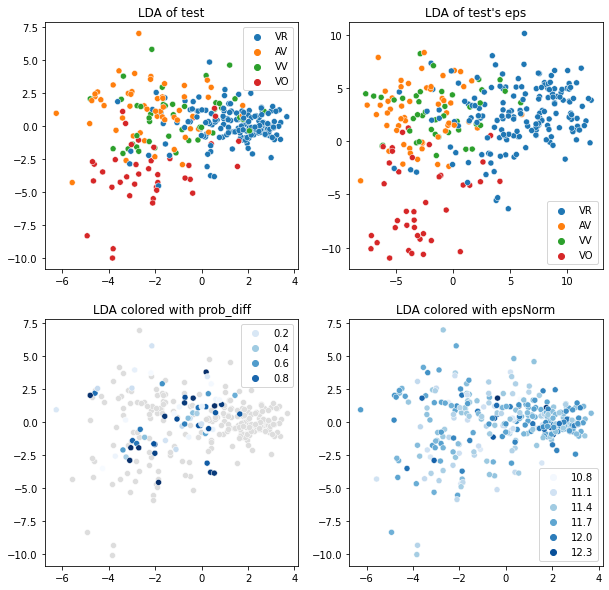

In [23]:
plot_eps_grids(testX_dc, testXeps_dc, testY, test_prob_diffs, test_epsNorm, "LDA", "test")

## TSNE plotly

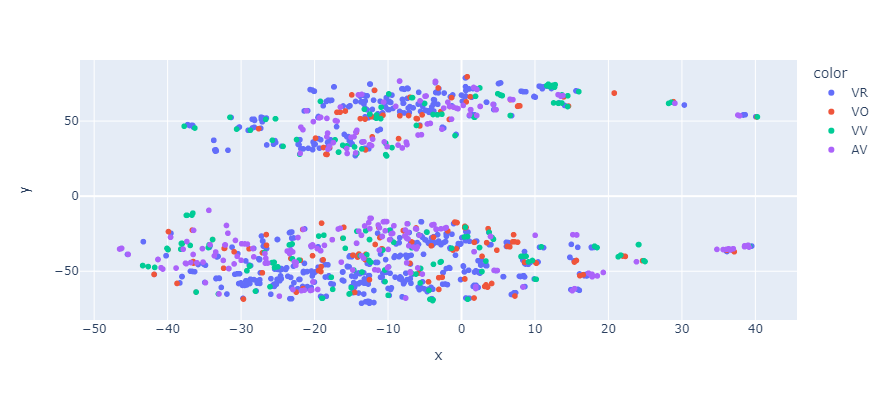

In [19]:
import plotly.express as px
train_words = [x["word"] for x in train_eps]
px.scatter(x=trainX_tsne[:,0], y=trainX_tsne[:,1], 
           color=trainY, hover_data=[train_words],
           width=600, height=400)